Using Euler time stepping

In [12]:
import numpy as np
from numpy import nanmedian
import pandas as pd
import os, glob
from pathlib import Path
import gsw
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import PyCO2SYS as pyco2
import xarray as xr
from datetime import datetime
from scipy.optimize import minimize
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import earthaccess as ea

# Setup

## Location, Time

In [23]:
# directories
rawDir = "../data/raw/"
windDir = "../data/raw/wind/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

In [24]:
# --- Simulation Settings ---
dt = 0.1  # years
total_time = 6  # years
nt = int(total_time / dt) # number of time steps
times = np.linspace(0, total_time, nt + 1)
print(times)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6. ]


In [25]:
# use 365.2425 d/yr (or set to 365.0 to match your conventions)
DAYS_PER_YEAR = 365.2425
SECONDS_PER_YEAR = DAYS_PER_YEAR * 86400.0

# choose the simulation start date in UTC
sim_start = pd.Timestamp("2013-01-01T00:00:00Z")
sim_end = sim_start + pd.to_timedelta(total_time * DAYS_PER_YEAR, unit="D")

start_time = sim_start.strftime("%Y-%m-%dT%H:%M:%SZ")
end_time   = (sim_end - pd.Timedelta(seconds=1)).strftime("%Y-%m-%dT%H:%M:%SZ")  # inclusive end

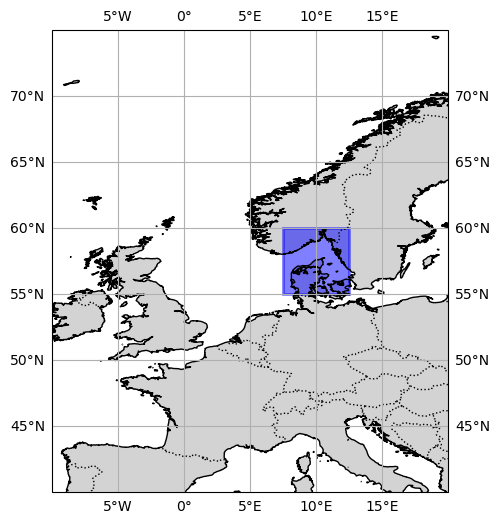

In [26]:
lat_min, lat_max = 55, 60
lon_min, lon_max = 7.5, 12.5

# --- Create a map ---
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-10, 20, 40, 75])  # wider map view around area


# --- Add rectangle for your lat/lon range ---
rect = Rectangle(
    (lon_min, lat_min),             # lower-left corner
    lon_max - lon_min,              # width (in degrees)
    lat_max - lat_min,              # height (in degrees)
    linewidth=2,
    edgecolor='blue',
    facecolor='blue',
    alpha=0.5,  # semi-transparent
    transform=ccrs.PlateCarree()
)

ax.add_patch(rect)
ax.gridlines(draw_labels=True)
plt.savefig(imgDir + "map_region.png", dpi=300)
plt.show()


## Parameter

In [27]:
params = {
    'T1_star': 8.9, # °C
    'T2_star': 8.3, # °C
    'S1_star': 35.1, # psu
    'S2_star': 35.1, # psu
    'A_1T': 3.50, # °C
    'A_1S': -0.3, # psu
    'A_2T': 2.5, # °C
    'phi_1T': -0.97, # radians
    'phi_1S': -0.45, # radians
    'phi_2T': -1.54, # radians
    'tau_1T': 0.09, # yr
    'tau_1S': 0.27, # yr
    'tau_2': 0.15, # yr
    'KD': 3e-5, # m^2/s
    'NPP': 250,   # g C m⁻² yr⁻¹ 
    'Fratio': 0.2, # unitless
    'PICPOC': 0.05, # unitless 
    'Remin': 1.0, # unitless
    'h1': 30.0, # m
    'h2': 60.0 # m
}

#'KD' m^2/s -> m^2/yr
KD_m2_yr = params['KD'] * SECONDS_PER_YEAR  # m^2/yr

# NPP  g C m⁻² yr⁻¹ -> µmol C kg⁻¹ yr⁻¹
rho = 1025.0  # kg m^-3
NPP_uM_kg_yr = params['NPP']  * (1e6 / 12.0) / (rho * params['h1']) # µmol C kg⁻¹ yr⁻¹
NCP = NPP_uM_kg_yr * params['Fratio']

# pCO2_atm is the atmospheric partial pressure of CO2
pCO2_atm = 420  # in µatm


delta_z = (params["h1"] + params["h2"])/2

In [28]:
# --- Initial Conditions ---
initial_state = np.array([
    8,  # T1 °C
    8,   # T2 °C
    35.1,  # S1 psu
    35.1,  # S2 psu
    1890.1, # DIC1 µmol/kg
    2019.0, # DIC2 µmol/kg
    2160.6, # TA1 µmol/kg
    2125.7  # TA2 µmol/kg
])

## Helper Functions

In [29]:
# Choose a single representative point for the box (fine for a 2-box model)
lon0 = (lon_min + lon_max) / 2.0  # ~10.0E for your box
lat0 = (lat_min + lat_max) / 2.0  # ~57.5N

# --- Function to compute potential density anomaly σ0 using TEOS-10 ---
def sigma0_from_TS(SP_psu, T_C, p_dbar, lon=lon0, lat=lat0):
    """
    Return potential density anomaly σ0 [kg m^-3 - 1000] using TEOS-10,
    given Practical Salinity (SP), in-situ T, and local sea pressure p (dbar).
    """
    SA = gsw.SA_from_SP(SP_psu, p_dbar, lon, lat)      # Absolute Salinity [g/kg]
    CT = gsw.CT_from_t(SA, T_C, p_dbar)                # Conservative Temp [°C]
    return gsw.sigma0(SA, CT) 

In [30]:
# -----------------------
# Air–sea CO2 gas-transfer 
# -----------------------
def schmidt_number_CO2_W14(temp_C):
    # Jähne et al. (1987) as listed in Wanninkhof (2014); dimensionless
    T = temp_C
    a, b, c, d, e = 2116.8, -136.25, 4.7353, -0.092307, 0.0007555
    return a + b*T + c*T**2 + d*T**3 + e*T**4

def k_W14_from_U2(U2, temp_C):
    """
    U2: <U^2> (m^2 s^-2) for the averaging window
    temp_C: temperature (°C) for Schmidt correction (scalar or array matching U2)
    Returns: k (in-situ) in cm hr^-1
    """
    Sc = schmidt_number_CO2_W14(temp_C)
    k = 0.251 * U2 * np.sqrt(660.0 / Sc)  # cm/hr
    return k

def K0_weiss74_CO2(temp_C, sal):
    """Weiss (1974) CO2 solubility: returns K0 in mol kg^-1 atm^-1."""
    T = temp_C + 273.15  # K
    A1, A2, A3 = -58.0931, 90.5069, 22.2940
    B1, B2, B3 = 0.027766, -0.025888, 0.0050578
    lnK0 = A1 + A2 * (100.0 / T) + A3 * np.log(T / 100.0) \
           + sal * (B1 + B2 * (T / 100.0) + B3 * (T / 100.0) ** 2)
    return np.exp(lnK0)  # mol kg^-1 atm^-1

In [31]:
def subset_box_0360(ds, lon_name="longitude", lat_name="latitude"):
    """Subset a 0–360° longitude grid to the desired box, 
    handling wrap-around across 0° if needed."""
    L0 = (np.asarray(lon_min) % 360 + 360) % 360
    L1 = (np.asarray(lon_max) % 360 + 360) % 360

    if L0 <= L1:
        return ds.sel({lon_name: slice(L0, L1), lat_name: slice(lat_min, lat_max)})
    else:
        # Box crosses 0° meridian: stitch two slices
        left  = ds.sel({lon_name: slice(L0, 360), lat_name: slice(lat_min, lat_max)})
        right = ds.sel({lon_name: slice(0,  L1), lat_name: slice(lat_min, lat_max)})
        return xr.concat([left, right], dim=lon_name)

## Wind

In [32]:
U2_file = Path("../data/interim/") / "U2_for_step.npy"

# -------------------------------------------------
# Check if U2_for_step already exists
# -------------------------------------------------
if U2_file.exists():
    print(f"Loading precomputed U2_for_step from {U2_file}")
    U2_for_step = np.load(U2_file)
    print(f"Loaded {len(U2_for_step)} steps from cached file.")
else:
    print("No cached U2_for_step found → downloading and computing …")

    # concept id for 6-hourly
    CCMP_6H_CONCEPT_ID = "C2916514952-POCLOUD"

    nc_files = sorted([p for p in Path(windDir).glob("*.nc*")])

    if not nc_files:
        print("No local CCMP 6-hourly files found -> logging in and downloading …")
        ea.login()
        granules = ea.search_data(
            concept_id=CCMP_6H_CONCEPT_ID,
            bounding_box=(lon_min, lat_min, lon_max, lat_max),  # metadata filter only; files are global
            temporal=(start_time, end_time),
        )
        files = ea.download(granules, local_path=windDir)  # save to your windDir
        nc_files = sorted([Path(f) for f in files if Path(f).suffix.startswith(".nc")])
    else:
        print(f"Found {len(nc_files)} CCMP 6-hourly file(s). Skipping download.")

    if not nc_files:
        raise FileNotFoundError("No CCMP .nc 6-hourly files available in windDir after check/download.")

    # -----------------------
    # Open CCMP 6-hourly chunks
    # -----------------------
    # chunks: time by 8 timesteps (~2 days), full lat/lon per chunk
    ds = xr.open_mfdataset(
        nc_files,
        combine="by_coords",
        chunks={"time": 8, "latitude": -1, "longitude": -1},
    )

    ds_box = subset_box_0360(ds, lon_name="longitude", lat_name="latitude")
    print(ds_box.sizes)
    print(float(ds_box.latitude.min()), "→", float(ds_box.latitude.max()))
    print(float(ds_box.longitude.min()), "→", float(ds_box.longitude.max()))

    # -----------------------
    # Native U^2 at 6-hourly resolution (m^2 s^-2)
    # -----------------------
    U2_6h = (ds_box["ws"] ** 2).rename("U2")
    U2_6h.attrs.update(units="m2 s-2", long_name="10 m wind second moment (native 6-hourly)")

    # -----------------------
    # Area-weighted spatial mean over your box
    # (lon spacing quasi-uniform; weight by cos(lat))
    # -----------------------
    lat = U2_6h["latitude"]
    weights_lat = np.cos(np.deg2rad(lat))
    weights_lat = weights_lat / weights_lat.mean()  # optional normalization

    U2_6h_wmean = (U2_6h * weights_lat).mean(dim=("latitude","longitude"))  # 1D over time


    # -----------------------
    # Bin 6-hourly values into model steps
    # -----------------------
    edges   = sim_start + pd.to_timedelta(times * DAYS_PER_YEAR, unit="D")
    centers = edges[:-1] + (edges[1:] - edges[:-1]) / 2
    edges   = pd.DatetimeIndex(edges).tz_localize(None)
    centers = pd.DatetimeIndex(centers).tz_localize(None)

    U2_binned = (
        U2_6h_wmean
        .groupby_bins("time", bins=edges, right=False)
        .mean()
        .dropna(dim="time_bins")
    )
    U2_step = U2_binned.rename({"time_bins": "time"}).assign_coords(
        time=("time", centers[:U2_binned.sizes["time_bins"]])
    )
    U2_step.attrs.update(units="m2 s-2", long_name="area-weighted U^2 (step-avg, CCMP 6h)")


    U2_for_step = U2_step.to_numpy()   # triggers one dask compute; tiny 1D array
    # quick sanity check:
    assert len(U2_for_step) == len(times) - 1, (len(U2_for_step), len(times)-1)

    # Save for later reuse
    np.save(U2_file, U2_for_step)

    print(f"times={len(times)}, centers={len(centers)}, U2_step time={U2_step.sizes['time']}")    
    print(f"Saved U2_for_step ({len(U2_for_step)} values) to {U2_file}")

Loading precomputed U2_for_step from ..\data\interim\U2_for_step.npy
Loaded 60 steps from cached file.


# Biogeochemical Model

In [68]:
# --- Initialize output ---
state = initial_state.copy()
states = [state.copy()]
pH_values = []
pCO2_surf_values = []
J_air_values = []

shock_time = 2.0  # year when the alkalinity shock occurs
shock_added = True  # flag to ensure it is only applied once
ENABLE_CONVECTION = False  # Set to False to disable density-driven mixing, the model runs purely diffusive mixing (via KD), ignoring overturning.

# --- Euler Integration Loop ---
for i, t in enumerate(times[1:], start=1):
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state # units °C, psu, µmol/kg, µmol/kg
    p = params

    # Apply alkalinity shock once
    if not shock_added and abs(t - shock_time) < 1e-6:  # very small tolerance for float comparison
        TA1 += 1000.0  # µmol/kg
        shock_added = True

    # Seasonal Forcing Terms
    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t + p['phi_1T']) # °C
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t + p['phi_2T']) # °C
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t + p['phi_1S']) # psu

    # Derivatives
    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T'] # °C/yr
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2'] # °C/yr
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S'] # psu/yr
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    # Calculate pCO2surf using PyCO2SYS
    co2sys_result = pyco2.sys(
    par1=TA1,
    par2=DIC1,
    par1_type=1,  # 1 = TA 
    par2_type=2,  # 2 = DIC
    salinity=S1,
    temperature=T1,
    pressure=0,  # sea surface pressure, in dbar

    total_silicate=0.0,     # explicitly zero
    total_phosphate=0.0,    # explicitly zero

    opt_k_carbonic=4,       # 4 = Mehrbach refit by Dickson & Millero (2007)
    opt_k_bisulfate=1,      # 1 = Dickson (1990)
    )

    pCO2_surf = co2sys_result['pCO2'] # µatm
    pCO2_surf_values.append(pCO2_surf)

    pH = co2sys_result['pH'] 
    pH_values.append(pH)

    # ------------------- Air-Sea CO2 Flux Calculation -------------------
    # wind forcing: O(1) array lookup now
    U2_now = U2_for_step[i-1]  # m^2 s^-2 for this model step

    # -- Compute k (cm/hr -> m/s) --
    k_cm_hr = float(k_W14_from_U2(U2_now, T1))                      # cm hr^-1 (in-situ)
    k_m_yr = k_cm_hr * (0.01 * 24.0 * DAYS_PER_YEAR)                # m yr^-1 (in-situ)

    # -- CO2 solubility K0 (Weiss 1974) --
    K0_mol_kg_atm = K0_weiss74_CO2(T1, S1)                          # mol kg^-1 atm^-1

    # -- Bulk air-sea CO2 flux F = k * K0 * Δp -- 
    delta_p_atm = (pCO2_atm - pCO2_surf) * 1e-6                     # atm
    J_air = (k_m_yr * K0_mol_kg_atm * delta_p_atm) / p['h1'] * 1e6  # µmol kg^-1 yr^-1                        
    J_air_values.append(J_air)
    # ----------------------------------------------------------------------

    # --- mixing (per mass) ---
    mix_DIC1 =  KD_m2_yr * ((DIC2 - DIC1) / delta_z) / p['h1']
    mix_DIC2 = -KD_m2_yr * ((DIC2 - DIC1) / delta_z) / p['h2']
    mix_TA1  =  KD_m2_yr * ((TA2  - TA1 ) / delta_z) / p['h1']
    mix_TA2  = -KD_m2_yr * ((TA2  - TA1 ) / delta_z) / p['h2']


    # --- biology (per mass) ---
    bio_DIC1 = -(NCP +              NCP * p['PICPOC'])
    bio_DIC2 =  (NCP * p['Remin'] + NCP * p['PICPOC'])
    bio_TA1  = -2.0 * NCP * p['PICPOC']
    bio_TA2  = +2.0 * NCP * p['PICPOC'] * p['Remin'] 

    # final tendencies (all in µmol kg^-1 yr^-1)
    dDIC1 = J_air + mix_DIC1 + bio_DIC1
    dDIC2 =         mix_DIC2 + bio_DIC2
    dTA1  =         mix_TA1  + bio_TA1
    dTA2  =         mix_TA2  + bio_TA2

    # Tentative Euler Step
    T1_hat = T1 + dt * dT1 # °C
    T2_hat = T2 + dt * dT2 # °C
    S1_hat = S1 + dt * dS1 # psu
    S2_hat = S2 + dt * dS2 # psu
    DIC1_hat = DIC1 + dt * dDIC1 # µmol/kg
    DIC2_hat = DIC2 + dt * dDIC2 # µmol/kg
    TA1_hat = TA1 + dt * dTA1   # µmol/kg
    TA2_hat = TA2 + dt * dTA2  # µmol/kg

    # --- Potential Density Mixing Condition ---
    if ENABLE_CONVECTION:
        # Pressures at representative depths (surface box near 0; deep at its mid-depth)
        p1 = 0.0
        p2 = p['h1'] + 0.5 * p['h2']  # meters ~ dbar

        #If sig1 > sig2: surface water is denser → convection occurs.
        #Else surface water is lighter → no convection.
        # Compute potential densities using TEOS-10
        sig1 = sigma0_from_TS(S1_hat, T1_hat, p1)
        sig2 = sigma0_from_TS(S2_hat, T2_hat, p2)

        # If surface water is denser → convective overturning
        if sig1 > sig2 - 1e-6:  # small tolerance to avoid numerical issues
            mix_T = (p['h1'] * T1_hat + p['h2'] * T2_hat) / (p['h1'] + p['h2']) # °C
            mix_S = (p['h1'] * S1_hat + p['h2'] * S2_hat) / (p['h1'] + p['h2']) # psu
            mix_DIC = (p['h1'] * DIC1_hat + p['h2'] * DIC2_hat) / (p['h1'] + p['h2']) # µmol/kg
            mix_TA = (p['h1'] * TA1_hat + p['h2'] * TA2_hat) / (p['h1'] + p['h2'])  # µmol/kg
            state = np.array([mix_T, mix_T, mix_S, mix_S, mix_DIC, mix_DIC, mix_TA, mix_TA])
        else:
            state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])
    else:
        # convection disabled → always take predicted values
        state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])

    states.append(state.copy())

# --- Save Results ---
columns = ['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2']
df = pd.DataFrame(states, columns=columns)
df['time'] = times

# Add a starting dummy value to match length
pH_values.insert(0, np.nan)
pCO2_surf_values.insert(0, np.nan)
J_air_values.insert(0, np.nan)

# Add to dataframe
df['pH'] = pH_values
df['pCO2_surf'] = pCO2_surf_values
df['J_air'] = J_air_values

# Save to CSV
df.to_csv(processedDir + "GB_model_output.csv", index=False)

## Trajectories

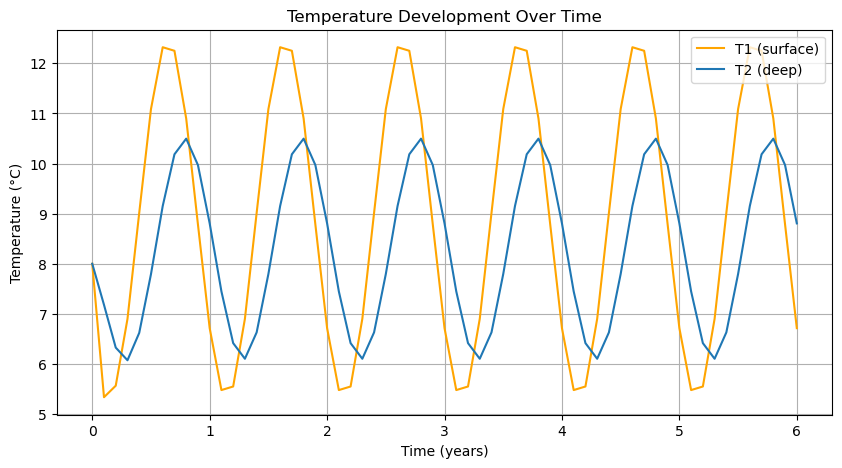

In [69]:
# --- Plotting: Temperature ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['T1'], label='T1 (surface)', color='orange')
plt.plot(df['time'], df['T2'], label='T2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Development Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "T1_T2_no_mixing.png", dpi=300)
plt.show()

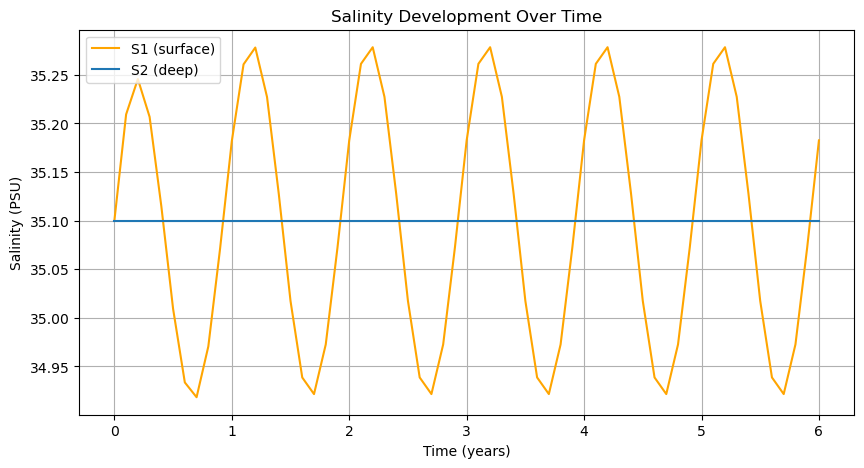

In [70]:
# --- Plotting: Salinity ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['S1'], label='S1 (surface)', color='orange')
plt.plot(df['time'], df['S2'], label='S2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Salinity (PSU)')
plt.title('Salinity Development Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "S1_S2_no_mixing.png", dpi=300)
plt.show()

In [71]:
print(df["DIC1"].describe())

count      61.000000
mean     1991.253258
std        29.278426
min      1890.100000
25%      1981.928354
50%      1998.452185
75%      2011.302250
max      2033.637960
Name: DIC1, dtype: float64


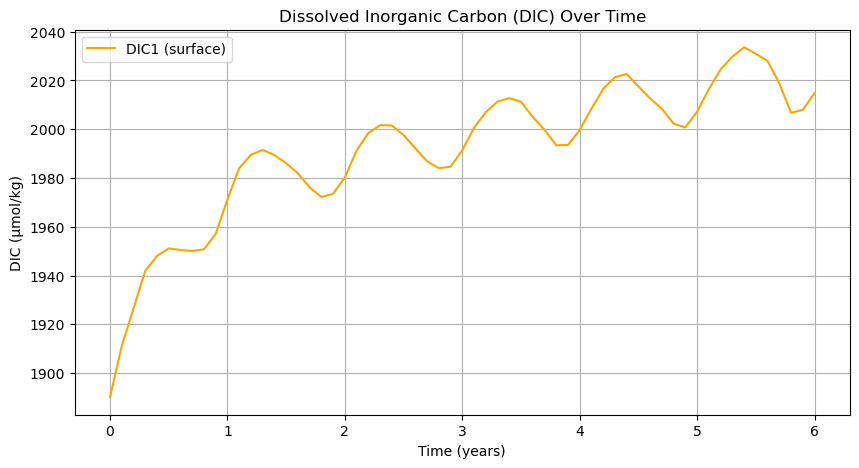

In [72]:
# --- Plotting: Disolved Inorganic Carbon ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['DIC1'], label='DIC1 (surface)', color='orange')
#plt.plot(df['time'], df['DIC2'], label='DIC2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('DIC (µmol/kg)')
plt.title('Dissolved Inorganic Carbon (DIC) Over Time')
plt.legend()
plt.grid(True)
# Disable offset/scientific notation
plt.gca().yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.savefig(imgDir + "DIC1_no_mixing.png", dpi=300)
plt.show()


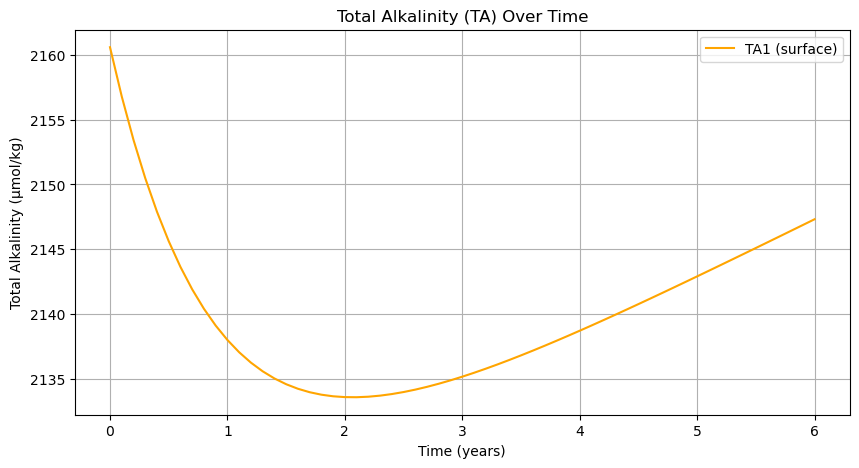

In [73]:
# --- Plotting: Alkalinity ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['TA1'], label='TA1 (surface)', color='orange')
#plt.plot(df['time'], df['TA2'], label='TA2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Total Alkalinity (µmol/kg)')
plt.title('Total Alkalinity (TA) Over Time')
# Disable offset/scientific notation
plt.gca().yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "T1_no_mixing.png", dpi=300)
plt.show()


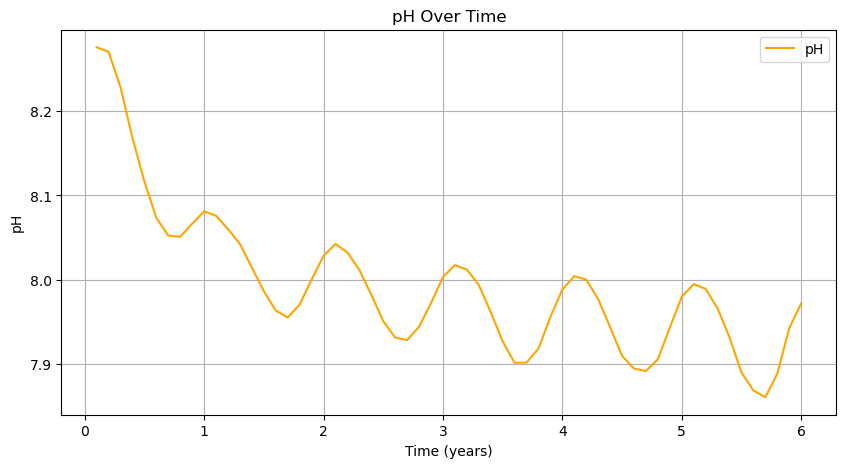

In [74]:
# --- Plotting: pH ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['pH'], label='pH', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('pH')
plt.title('pH Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "pH_no_mixing.png", dpi=300)
plt.show()

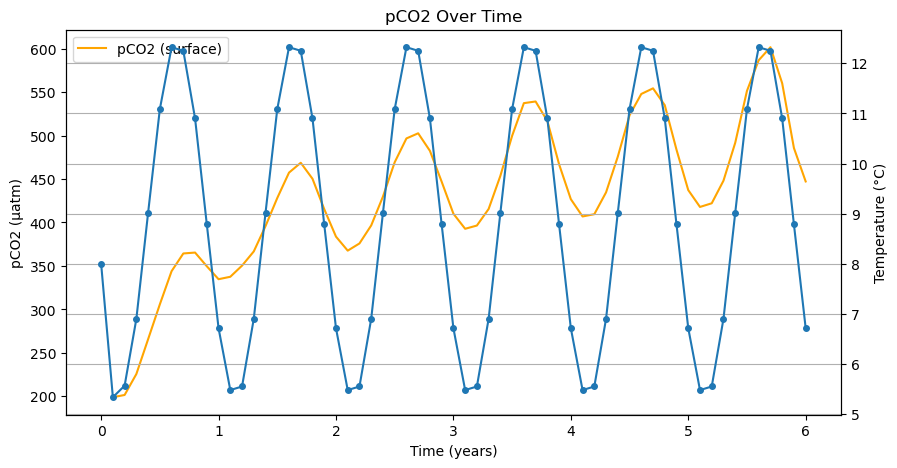

In [75]:
# --- Plotting: pCO2 ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['pCO2_surf'], label='pCO2 (surface)', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('pCO2 (µatm)')
plt.title('pCO2 Over Time')
plt.legend()
# second axis for temperature
ax2 = plt.gca().twinx()
ax2.set_ylabel('Temperature (°C)')
ax2.tick_params(axis='y')
plt.plot(df['time'], df['T1'], linestyle='-', marker='o', markersize=4)
plt.grid(True)
plt.savefig(imgDir + "pCO2_T1_no_mixing.png", dpi=300)
plt.show()

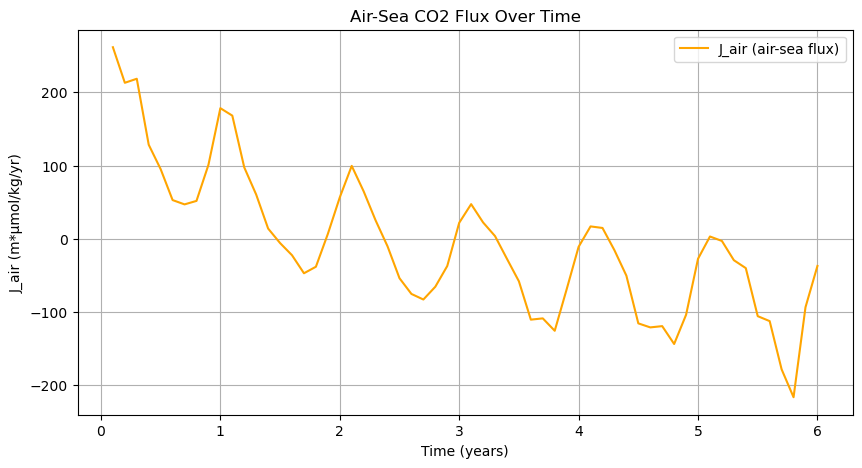

In [76]:
# --- Plotting: J_air ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['J_air'], label='J_air (air-sea flux)', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('J_air (m*µmol/kg/yr)')
plt.title('Air-Sea CO2 Flux Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "J_air_no_mixing.png", dpi=300)
plt.show()

## Timing

In [42]:
# Anchor on your sim_start and use your DAYS_PER_YEAR
sim_start_naive = (pd.Timestamp(sim_start).tz_convert("UTC").tz_localize(None)
                   if pd.Timestamp(sim_start).tz is not None
                   else pd.Timestamp(sim_start))

# Exact datetime for each model step
df["date_exact"] = sim_start_naive + pd.to_timedelta(df["time"] * DAYS_PER_YEAR, unit="D")

# Month-start timestamps (start of month)
df["date_month_start"] = df["date_exact"].dt.to_period("M").dt.to_timestamp(how="start")


print(df.head())


         T1        T2         S1         S2         DIC1         DIC2  \
0  8.000000  8.000000  35.100000  35.100000  1890.100000  2019.000000   
1  6.564842  6.564842  35.136450  35.136450  1989.495091  1989.495091   
2  5.890688  5.890688  35.141377  35.141377  1995.574929  1995.574929   
3  6.862823  5.928412  35.141099  35.113792  1985.600866  2009.802571   
4  9.019336  6.571811  35.073343  35.104597  1976.756124  2023.181622   

           TA1          TA2  time        pH   pCO2_surf       J_air  \
0  2160.600000  2125.700000   0.0       NaN         NaN         NaN   
1  2137.785005  2137.785005   0.1  8.275905  199.001516  261.576321   
2  2138.236676  2138.236676   0.2  8.031895  378.629723   40.118700   
3  2136.881662  2139.591689   0.3  8.027662  382.132488   42.535789   
4  2135.716693  2140.851680   0.4  8.034991  375.728006   36.857185   

               date_exact date_month_start  
0 2013-01-01 00:00:00.000       2013-01-01  
1 2013-02-06 12:34:55.200       2013-02-01  

# SOCAT data

In [43]:
# Open the dataset
socat_data = xr.open_dataset(rawDir + "SOCATv2024_tracks_gridded_monthly.nc")

# List all variables
print("Variables:\n", list(socat_data.data_vars))

Variables:
 ['tmnth_bnds', 'count_ncruise', 'fco2_count_nobs', 'fco2_ave_weighted', 'fco2_ave_unwtd', 'fco2_min_unwtd', 'fco2_max_unwtd', 'fco2_std_weighted', 'fco2_std_unwtd', 'sst_count_nobs', 'sst_ave_weighted', 'sst_ave_unwtd', 'sst_min_unwtd', 'sst_max_unwtd', 'sst_std_weighted', 'sst_std_unwtd', 'salinity_count_nobs', 'salinity_ave_weighted', 'salinity_ave_unwtd', 'salinity_min_unwtd', 'salinity_max_unwtd', 'salinity_std_weighted', 'salinity_std_unwtd', 'lat_offset_unwtd', 'lon_offset_unwtd']


In [44]:
# keep your local tz-naive endpoints
sel_start = sim_start.tz_localize(None)
sel_end   = sim_end.tz_localize(None)

# numpy datetime64 endpoints (ns precision)
start64 = np.datetime64(sel_start, "ns")
end64   = np.datetime64(sel_end,   "ns")

# make a DataArray mask on the 'tmnth' coord
tm = socat_data["tmnth"]
cond = (tm >= start64) & (tm <= end64)   # this is a DataArray (good)

# spatial + temporal subset
socat_norway_data = socat_data[
    ["sst_ave_weighted", "salinity_ave_weighted", "fco2_ave_weighted"]
].sel(ylat=slice(lat_min, lat_max), xlon=slice(lon_min, lon_max)) \
 .where(cond, drop=True)

# area mean
socat_mean = socat_norway_data.mean(dim=["xlon","ylat"], skipna=True)

# sanity check
print(pd.to_datetime(socat_mean["tmnth"].values))

DatetimeIndex(['2013-01-16 12:00:00', '2013-02-15 00:00:00',
               '2013-03-16 12:00:00', '2013-04-16 00:00:00',
               '2013-05-16 12:00:00', '2013-06-16 00:00:00',
               '2013-07-16 12:00:00', '2013-08-16 12:00:00',
               '2013-09-16 00:00:00', '2013-10-16 12:00:00',
               '2013-11-16 00:00:00', '2013-12-16 12:00:00',
               '2014-01-16 12:00:00', '2014-02-15 00:00:00',
               '2014-03-16 12:00:00', '2014-04-16 00:00:00',
               '2014-05-16 12:00:00', '2014-06-16 00:00:00',
               '2014-07-16 12:00:00', '2014-08-16 12:00:00',
               '2014-09-16 00:00:00', '2014-10-16 12:00:00',
               '2014-11-16 00:00:00', '2014-12-16 12:00:00',
               '2015-01-16 12:00:00', '2015-02-15 00:00:00',
               '2015-03-16 12:00:00', '2015-04-16 00:00:00',
               '2015-05-16 12:00:00', '2015-06-16 00:00:00',
               '2015-07-16 12:00:00', '2015-08-16 12:00:00',
               '2015-09-

In [45]:
# Convert area mean to pandas DataFrame
socat_mean_df = socat_mean.to_dataframe().reset_index()

# Rename for consistency
socat_mean_df = socat_mean_df.rename(columns={
    'tmnth': 'date_exact',
    'sst_ave_weighted': 'T1_obs',
    'salinity_ave_weighted': 'S1_obs',
    'fco2_ave_weighted': 'pCO2_obs'
})

socat_mean_df["date_month_start"] = socat_mean_df["date_exact"].dt.to_period("M").dt.to_timestamp(how="start")

print(socat_mean_df.head())

           date_exact     T1_obs  S1_obs    pCO2_obs date_month_start
0 2013-01-16 12:00:00   4.976562     NaN  359.240692       2013-01-01
1 2013-02-15 00:00:00   3.488896     NaN  356.201538       2013-02-01
2 2013-03-16 12:00:00   3.033853     NaN  272.073975       2013-03-01
3 2013-04-16 00:00:00   4.863231     NaN  284.647736       2013-04-01
4 2013-05-16 12:00:00  11.073807     NaN  348.573273       2013-05-01


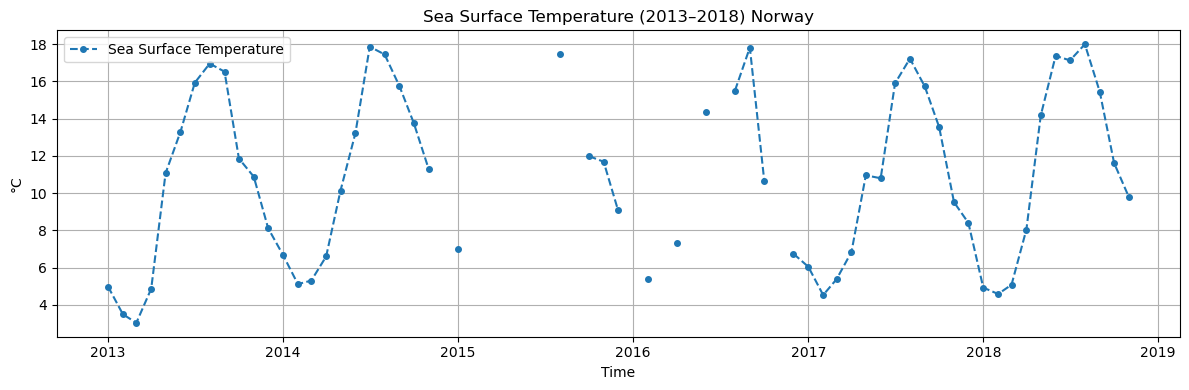

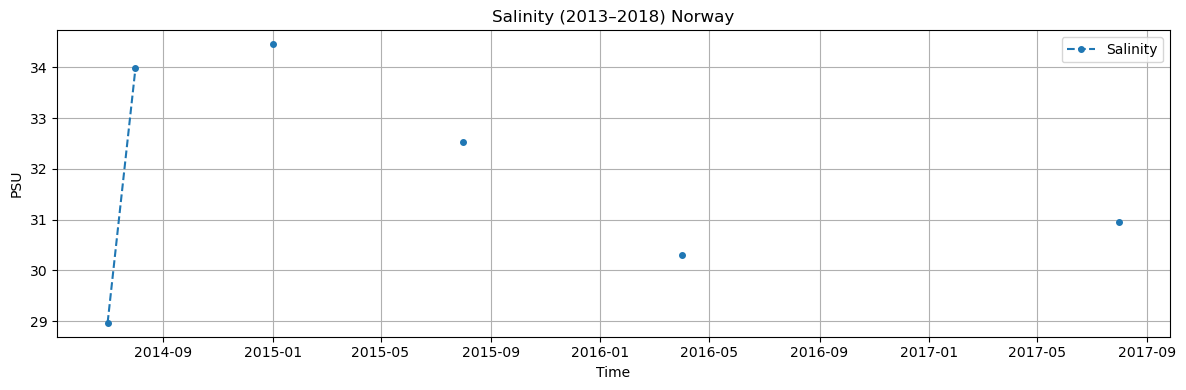

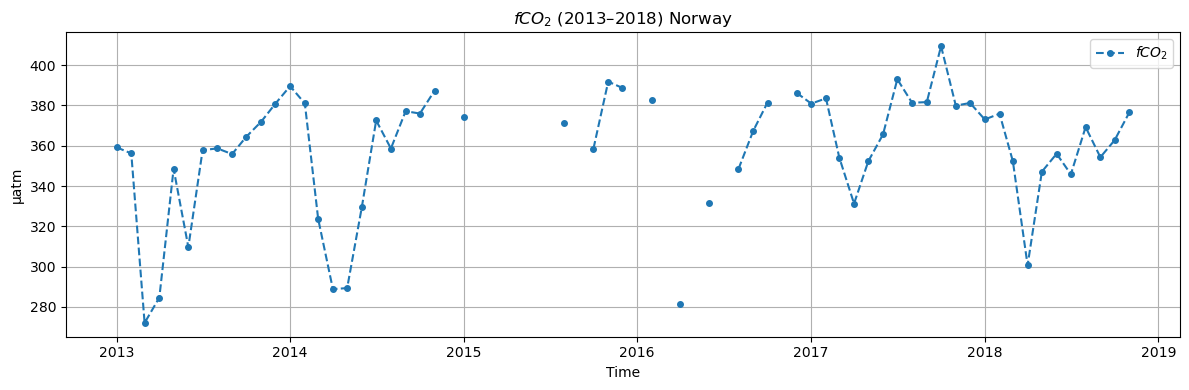

In [46]:
# --- Plot helper function ---
def plot_time_series(df, var, label, ylabel):
    plt.figure(figsize=(12, 4))
    plt.plot(df["date_month_start"], df[var],
             label=label, linestyle='--', marker='o', markersize=4)
    plt.title(f"{label} (2013–2018) Norway")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(imgDir + f"{var}_time_series.png", dpi=300)
    plt.show()

# --- Plot each observed variable ---
plot_time_series(socat_mean_df, 'T1_obs', 'Sea Surface Temperature', '°C')
plot_time_series(socat_mean_df, 'S1_obs', 'Salinity', 'PSU')
plot_time_series(socat_mean_df, 'pCO2_obs', r'$fCO_2$', 'µatm')

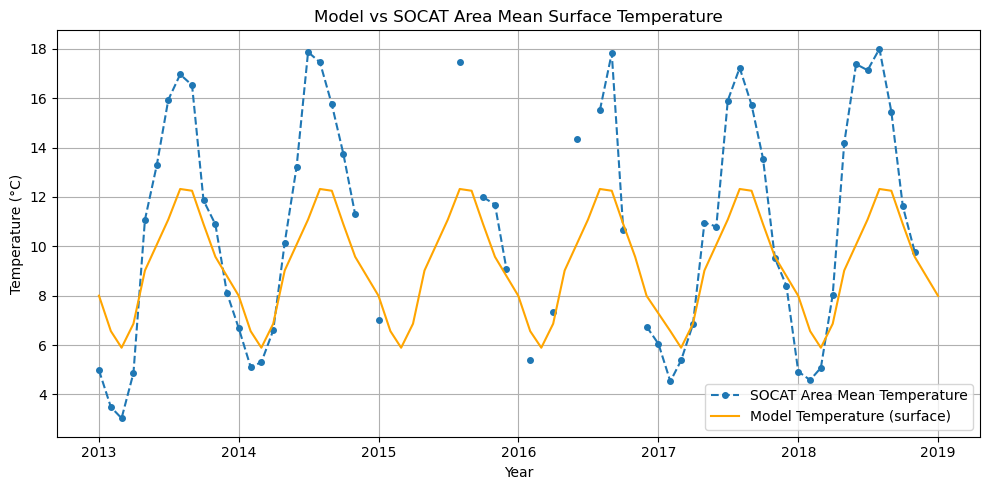

In [47]:
# --- Plot: Model vs SOCAT Surface Temperature ---
plt.figure(figsize=(10, 5))
plt.plot(socat_mean_df['date_month_start'], socat_mean_df['T1_obs'],
         label='SOCAT Area Mean Temperature', linestyle='--', marker='o', markersize=4)
plt.plot(df['date_month_start'], df['T1'], label='Model Temperature (surface)', color='orange')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Model vs SOCAT Area Mean Surface Temperature')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "GB_model_vs_SOCAT_Temperature.png", dpi=300)
plt.show()

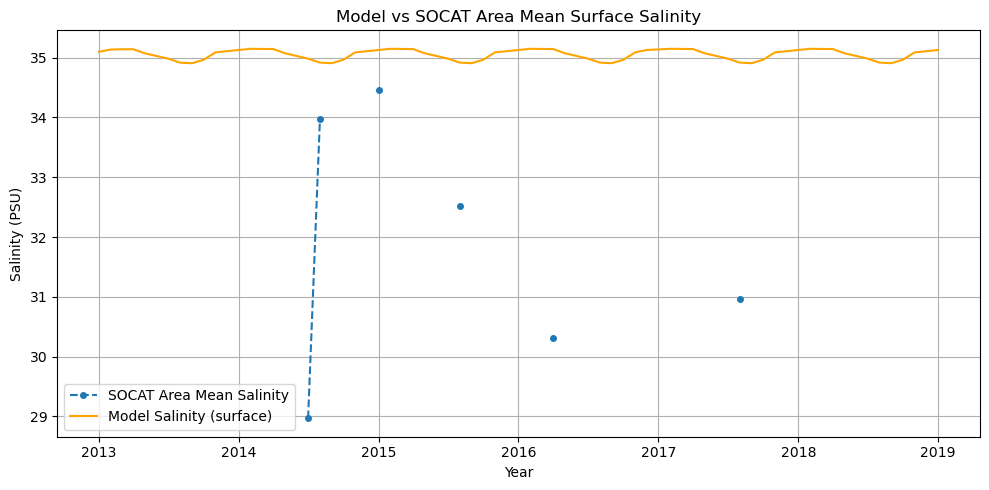

In [48]:
# --- Plot: Model vs SOCAT Surface Salinity ---
plt.figure(figsize=(10, 5))
plt.plot(socat_mean_df['date_month_start'], socat_mean_df['S1_obs'],
         label='SOCAT Area Mean Salinity', linestyle='--', marker='o', markersize=4)
plt.plot(df['date_month_start'], df['S1'], label='Model Salinity (surface)', color='orange')
plt.xlabel('Year')
plt.ylabel('Salinity (PSU)')
plt.title('Model vs SOCAT Area Mean Surface Salinity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "GB_model_vs_SOCAT_Salinity.png", dpi=300)
plt.show()

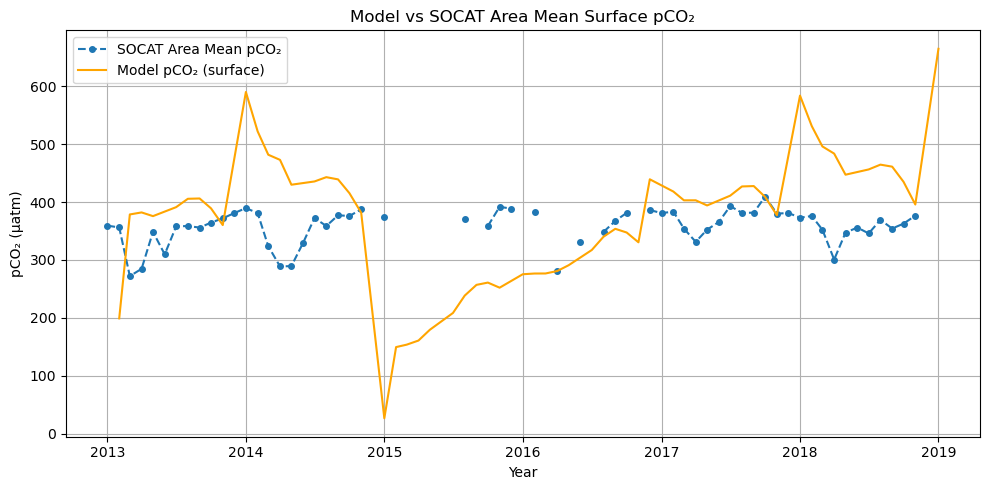

In [49]:
# --- Plot: Model vs SOCAT Surface pCO₂ ---
plt.figure(figsize=(10, 5))
plt.plot(socat_mean_df['date_month_start'], socat_mean_df['pCO2_obs'],
         label='SOCAT Area Mean pCO₂', linestyle='--', marker='o', markersize=4)
plt.plot(df['date_month_start'], df['pCO2_surf'], label='Model pCO₂ (surface)', color='orange')
plt.xlabel('Year')
plt.ylabel('pCO₂ (µatm)')
plt.title('Model vs SOCAT Area Mean Surface pCO₂')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "GB_model_vs_SOCAT_pCO2.png", dpi=300)
plt.show()

# Glodap data

In [50]:
df_glodap = pd.read_csv(rawDir + "GLODAPv2.2023_Merged_Master_File.csv", low_memory=False)


In [51]:
# Basic structure
print(df_glodap.shape)             # Number of rows and columns
print(df_glodap.columns.tolist())  # List of column names

# set all -9999 to NaN
df_glodap.replace(-9999, np.nan, inplace=True)

(1402829, 109)
['G2expocode', 'G2cruise', 'G2station', 'G2region', 'G2cast', 'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute', 'G2latitude', 'G2longitude', 'G2bottomdepth', 'G2maxsampdepth', 'G2bottle', 'G2pressure', 'G2depth', 'G2temperature', 'G2theta', 'G2salinity', 'G2salinityf', 'G2salinityqc', 'G2sigma0', 'G2sigma1', 'G2sigma2', 'G2sigma3', 'G2sigma4', 'G2gamma', 'G2oxygen', 'G2oxygenf', 'G2oxygenqc', 'G2aou', 'G2aouf', 'G2nitrate', 'G2nitratef', 'G2nitrateqc', 'G2nitrite', 'G2nitritef', 'G2silicate', 'G2silicatef', 'G2silicateqc', 'G2phosphate', 'G2phosphatef', 'G2phosphateqc', 'G2tco2', 'G2tco2f', 'G2tco2qc', 'G2talk', 'G2talkf', 'G2talkqc', 'G2fco2', 'G2fco2f', 'G2fco2temp', 'G2phts25p0', 'G2phts25p0f', 'G2phtsinsitutp', 'G2phtsinsitutpf', 'G2phtsqc', 'G2cfc11', 'G2pcfc11', 'G2cfc11f', 'G2cfc11qc', 'G2cfc12', 'G2pcfc12', 'G2cfc12f', 'G2cfc12qc', 'G2cfc113', 'G2pcfc113', 'G2cfc113f', 'G2cfc113qc', 'G2ccl4', 'G2pccl4', 'G2ccl4f', 'G2ccl4qc', 'G2sf6', 'G2psf6', 'G2sf6f', 'G2sf6

In [52]:
# 1) Make sure the key columns are numeric
for col in ['G2latitude','G2longitude','G2year','G2month','G2day','G2depth']:
    df_glodap[col] = pd.to_numeric(df_glodap[col], errors='coerce')

# 2) Quick stats (ignore NaNs)
lat_min_data  = np.nanmin(df_glodap['G2latitude'].values)
lat_max_data  = np.nanmax(df_glodap['G2latitude'].values)
lon_min_data  = np.nanmin(df_glodap['G2longitude'].values)
lon_max_data  = np.nanmax(df_glodap['G2longitude'].values)
year_min_data = np.nanmin(df_glodap['G2year'].values)
year_max_data = np.nanmax(df_glodap['G2year'].values)

print(df_glodap[['G2latitude','G2longitude','G2year']].dtypes)
print("Years in file:", int(year_min_data), "→", int(year_max_data))
print("Lon range in file:", lon_min_data, "→", lon_max_data)
print("Lat range in file:", lat_min_data, "→", lat_max_data)

# 3) See which filter is knocking things out
m_lat = df_glodap['G2latitude'].between(lat_min, lat_max)
m_lon = df_glodap['G2longitude'].between(lon_min, lon_max)
m_yr  = (df_glodap['G2year'] >= sim_start.year) & (df_glodap['G2year'] <= sim_end.year)

print("Rows total:", len(df_glodap))
print("Pass lat:", int(m_lat.sum()))
print("Pass lon:", int(m_lon.sum()))
print("Pass year:", int(m_yr.sum()))
print("Pass all:", int((m_lat & m_lon & m_yr).sum()))


G2latitude     float64
G2longitude    float64
G2year         float64
dtype: object
Years in file: 1972 → 2021
Lon range in file: -180.0 → 236.7562
Lat range in file: -78.638 → 90.0
Rows total: 1402829
Pass lat: 60885
Pass lon: 14622
Pass year: 258029
Pass all: 0


In [53]:
# Define your analysis years dynamically from the model run
year_min = sim_start.year
year_max = sim_end.year

print(f"Filtering GLODAP data for years {year_min}–{year_max}")
df_filtered = df_glodap[
    (df_glodap['G2latitude'].between(lat_min, lat_max)) &
    (df_glodap['G2longitude'].between(lon_min, lon_max)) &
    (df_glodap['G2year'] >= year_min) &
    (df_glodap['G2year'] <= year_max)
]

Filtering GLODAP data for years 2013–2019


In [54]:
# Surface and deep cutoffs 
surface_depth = params['h1']  
deep_depth = params['h2']  	

# --- Subset Surface and Deep Layers ---
df_surface = df_filtered[df_filtered['G2depth'] <= surface_depth].copy()
df_deep = df_filtered[
    (df_filtered['G2depth'] > surface_depth) &
    (df_filtered['G2depth'] <= deep_depth)
].copy()

# --- Select relevant variables ---
vars_of_interest = [
    'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute',
    'G2temperature', 'G2salinity', 'G2tco2',
    'G2talk', 'G2fco2', 'G2phts25p0'
]
df_surface = df_surface[vars_of_interest].copy()
df_deep = df_deep[vars_of_interest].copy()

# --- Combine year + month into proper datetime ---
df_surface['date_exact'] = pd.to_datetime(
    dict(year=df_surface['G2year'], month=df_surface['G2month'], day=df_surface['G2day'], hour=df_surface['G2hour'], minute=df_surface['G2minute'])
)
df_deep['date_exact'] = pd.to_datetime(
    dict(year=df_deep['G2year'], month=df_deep['G2month'], day=df_deep['G2day'], hour=df_deep['G2hour'], minute=df_deep['G2minute'])
)

# --- Create "month start" column for alignment ---
df_surface['date_month_start'] = df_surface['date_exact'].dt.to_period("M").dt.to_timestamp(how="start")
df_deep['date_month_start'] = df_deep['date_exact'].dt.to_period("M").dt.to_timestamp(how="start")

# --- Monthly means ---
df_surface_monthly = df_surface.groupby('date_month_start').mean(numeric_only=True).reset_index()
df_deep_monthly = df_deep.groupby('date_month_start').mean(numeric_only=True).reset_index()

# --- Select relevant output variables ---
vars_of_interest = [
    'date_month_start', 
    'G2temperature', 'G2salinity', 'G2tco2',
    'G2talk', 'G2fco2', 'G2phts25p0'
]
df_surface_monthly = df_surface_monthly[vars_of_interest].copy()
df_deep_monthly  = df_deep_monthly[vars_of_interest].copy()

# --- Rename for consistency with your model ---
df_surface_monthly = df_surface_monthly.rename(columns={
    'G2temperature': 'T1_obs',
    'G2salinity': 'S1_obs',
    'G2tco2': 'DIC1_obs',
    'G2talk': 'TA1_obs',
    'G2fco2': 'pCO2_obs',
    'G2phts25p0': 'pH_obs'
})

df_deep_monthly = df_deep_monthly.rename(columns={
    'G2temperature': 'T2_obs',
    'G2salinity': 'S2_obs',
    'G2tco2': 'DIC2_obs',
    'G2talk': 'TA2_obs',
    'G2fco2': 'pCO2_obs',
    'G2phts25p0': 'pH_obs'
})

print("Surface Data Sample:\n", df_surface_monthly.head())
print("Deep Data Sample:\n", df_deep_monthly.head())


Surface Data Sample:
 Empty DataFrame
Columns: [date_month_start, T1_obs, S1_obs, DIC1_obs, TA1_obs, pCO2_obs, pH_obs]
Index: []
Deep Data Sample:
 Empty DataFrame
Columns: [date_month_start, T2_obs, S2_obs, DIC2_obs, TA2_obs, pCO2_obs, pH_obs]
Index: []


In [55]:
def plot_model_vs_glodap(model_df, obs_df, var_model, var_obs,
                         title=None):
    plt.figure(figsize=(12, 4))

    # Plot GLODAP observational data
    plt.plot(obs_df['date_month_start'], obs_df[var_obs], label=f'GLODAP: {var_obs}', linestyle='--', marker='o', markersize=4)

    # Plot model data
    plt.plot(model_df['date_month_start'], model_df[var_model], label=f'Model: {var_model}')

    # Title and labels
    plot_title = title
    plt.title(plot_title)
    plt.xlabel("Year")
    plt.ylabel(var_model.replace('_', ' '))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


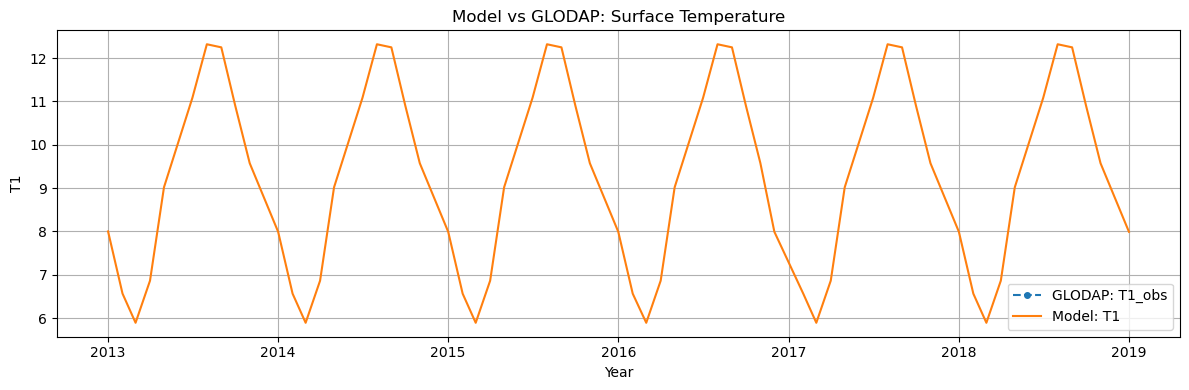

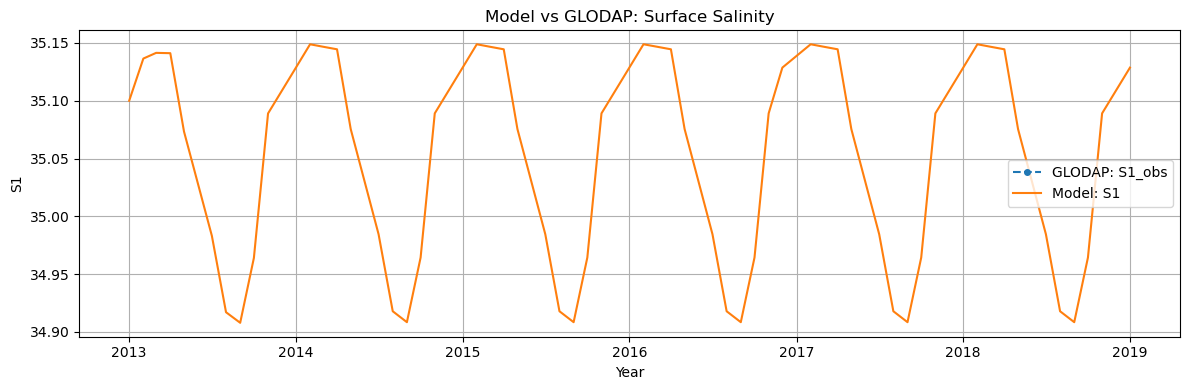

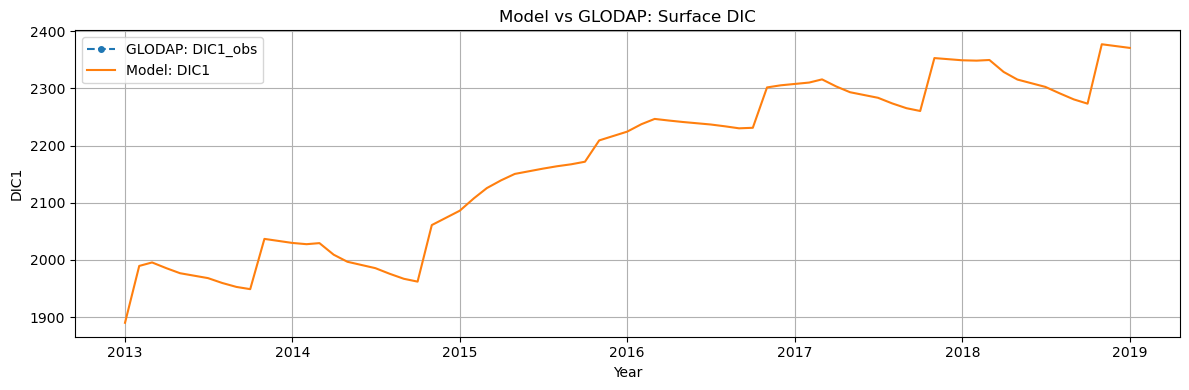

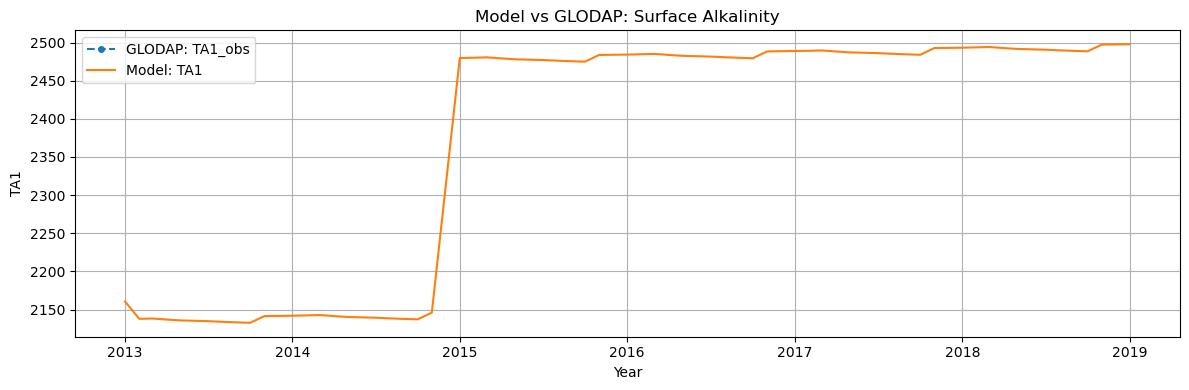

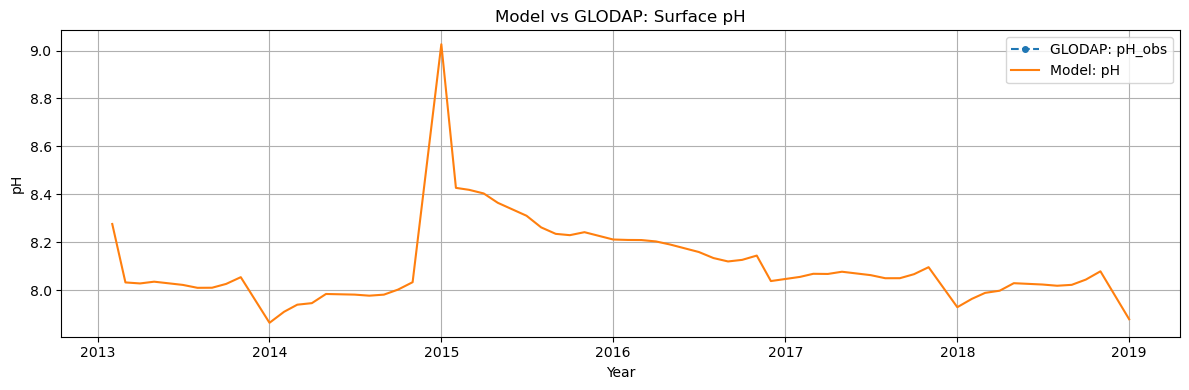

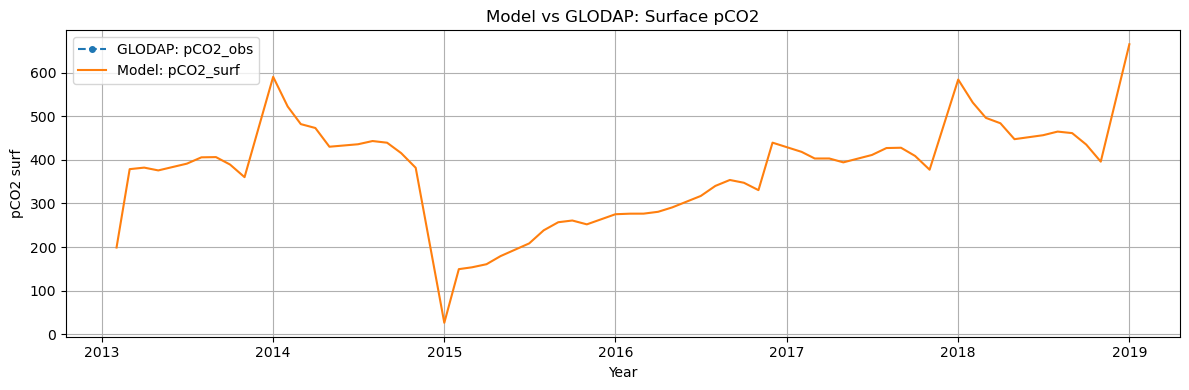

In [56]:
plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='T1',         # model variable name in df
    var_obs='T1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Temperature'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='S1',         # model variable name in df
    var_obs='S1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Salinity'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='DIC1',         # model variable name in df
    var_obs='DIC1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface DIC'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='TA1',         # model variable name in df
    var_obs='TA1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Alkalinity'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='pH',         # model variable name in df
    var_obs='pH_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface pH'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='pCO2_surf',         # model variable name in df
    var_obs='pCO2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface pCO2'
)

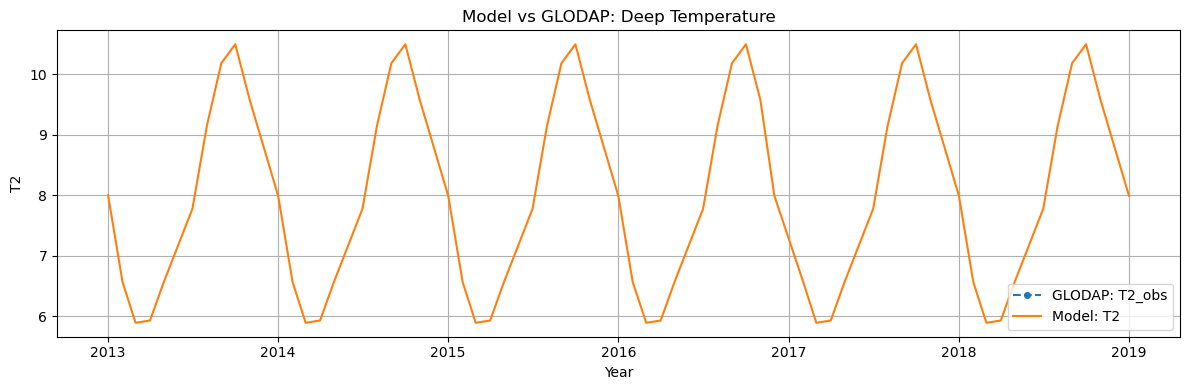

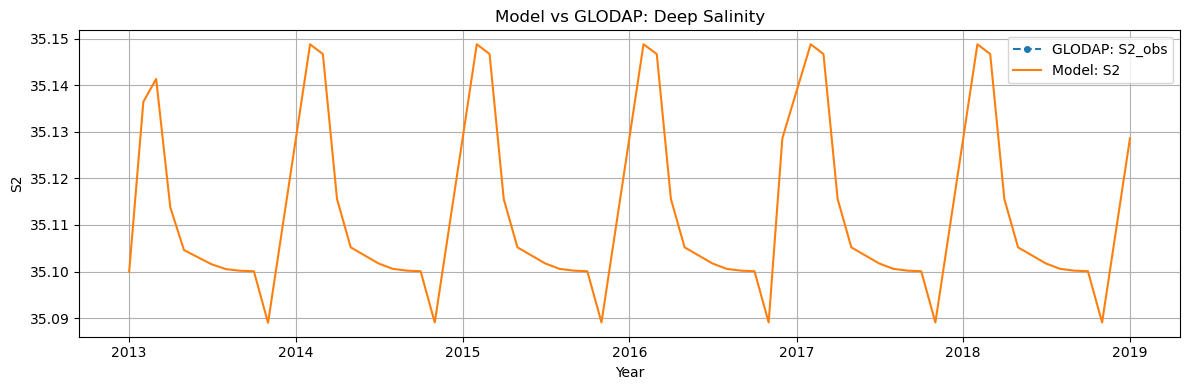

In [57]:
plot_model_vs_glodap(
    model_df=df,
    obs_df=df_deep_monthly,
    var_model='T2',         # model variable name in df
    var_obs='T2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Deep Temperature'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_deep_monthly,
    var_model='S2',         # model variable name in df
    var_obs='S2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Deep Salinity'
)